## Teoria Uczenia Maszynowego - miniprojekt
## Temat: Przebieg procesu uczenia dla sieci neuronowej przy użyciu różnych algorytmów optymalizacji
### Michał Ciesielski 145325
Do zbadania tego problemu posłużę się zbiorem danych *Airline Passenger Satisfaction*. Będzie on dotyczył problemu klasyfikacji binarnej. Zawiera on dane z ankiety określającej, czy dany pasażer, klient linii lotniczych jest z nich zadowolony. Klasa pozytywna odpowiada za zadowolenie klienta z odbytej podróży, klasa negatywna oznacza neutralną lub negatywną opinię o danej linii lotniczej. Poniżej znajduje się link źródłowy zbioru.

https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction/data

Do zbadania problemu wykorzystana zostanie prosta sieć typu *Feed-Forward* wraz z kilkoma algorytmami optymalizacyjnymi dostępnymi w bibliotece *PyTorch*. Na wstępie dokonana zostanie eksploracyjna analiza danych zbioru, zgodnie z dobrą praktyką. Najważniejsza część rozwiązania znajduje się po wykresie korelacji zmiennych.

In [ ]:
#@title Running needed imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from typing import Tuple
import warnings
warnings.filterwarnings("ignore")

## Dataset: *Airline Passenger Satisfaction*
#### Eksploracyjna Analiza Danych

In [ ]:
#@title Read data into dataframes
airline_train_df = pd.read_csv('./airline_passenger_satisfaction_train.csv')
airline_test_df = pd.read_csv('./airline_passenger_satisfaction_test.csv')

In [ ]:
#@title Data dimensions
print("Train set dimensions:", airline_train_df.shape)
print("Test set dimensions:", airline_test_df.shape)

Train set dimensions: (103904, 25)
Test set dimensions: (25976, 25)


In [ ]:
#@title Head of the read training dataset
airline_train_df.head(10)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied
5,5,111157,Female,Loyal Customer,26,Personal Travel,Eco,1180,3,4,...,1,3,4,4,4,4,1,0,0.0,neutral or dissatisfied
6,6,82113,Male,Loyal Customer,47,Personal Travel,Eco,1276,2,4,...,2,3,3,4,3,5,2,9,23.0,neutral or dissatisfied
7,7,96462,Female,Loyal Customer,52,Business travel,Business,2035,4,3,...,5,5,5,5,4,5,4,4,0.0,satisfied
8,8,79485,Female,Loyal Customer,41,Business travel,Business,853,1,2,...,1,1,2,1,4,1,2,0,0.0,neutral or dissatisfied
9,9,65725,Male,disloyal Customer,20,Business travel,Eco,1061,3,3,...,2,2,3,4,4,3,2,0,0.0,neutral or dissatisfied


In [ ]:
#@title Info about datasets
airline_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [ ]:
#@title Sum of NAs' values for training set
airline_train_df.isna().sum()

Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction    

In [ ]:
#@title Sum of NAs' values for testing set
airline_test_df.isna().sum()

Unnamed: 0                            0
id                                    0
Gender                                0
Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                 0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             83
satisfaction                          0


Usunięcie niepotrzebnych kolumn

In [ ]:
#@title Drop useless columns
airline_train_df = airline_train_df.drop(['Unnamed: 0', 'id'], axis=1)
airline_test_df = airline_test_df.drop(['Unnamed: 0', 'id'], axis=1)

Binaryzacja atrybutu decyzyjnego

In [ ]:
#@title Binarize target variable
airline_train_df['satisfaction'].replace({'neutral or dissatisfied': 0, 'satisfied': 1}, inplace = True)
airline_test_df['satisfaction'].replace({'neutral or dissatisfied': 0, 'satisfied': 1}, inplace = True)

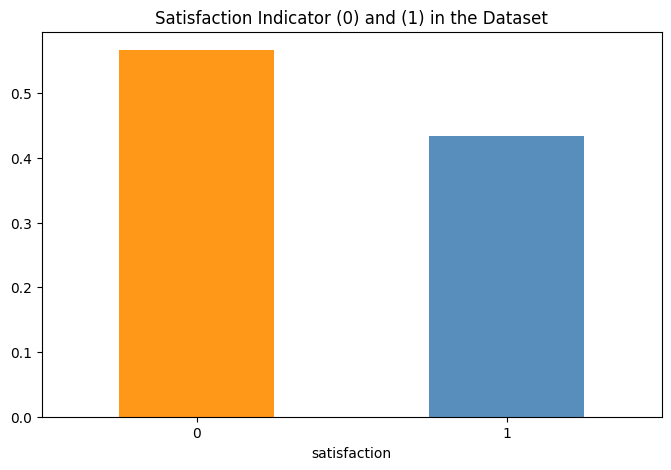

In [ ]:
#@title Target classes count plot
fig = plt.figure(figsize = (8,5))
airline_train_df.satisfaction.value_counts(normalize = True).plot(kind='bar', color= ['darkorange','steelblue'], alpha = 0.9, rot=0)
plt.title('Satisfaction Indicator (0) and (1) in the Dataset')
plt.show()

Powyższy wykres pokazuje stosunek 55%/45% pomiędzy liczbą neutralnych/niezadowolonych klientów a liczbą zadowolonych pasażerów z podróży. Dane są więc w przybliżeniu zbalansowane i nie wymagają specjalnego traktowania klasy mniejszościowej.

##### Obsługa brakujących wartości

In [ ]:
#@title Null values in training set columns
total = airline_train_df.isnull().sum().sort_values(ascending=False)
percent = (airline_train_df.isnull().sum()/airline_train_df.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head()

,Total,Percent
Arrival Delay in Minutes,310,0.002984
Gender,0,0.000000
Seat comfort,0,0.000000
Departure Delay in Minutes,0,0.000000
Cleanliness,0,0.000000


In [ ]:
#@title Change column names (replace space with underscores)
airline_train_df.columns = [c.replace(' ', '_') for c in airline_train_df.columns]
airline_test_df.columns = [c.replace(' ', '_') for c in airline_test_df.columns]

In [ ]:
#@title Fill null values with mean for a missing values in the numerical column
airline_train_df['Arrival_Delay_in_Minutes'] = airline_train_df['Arrival_Delay_in_Minutes'].fillna(airline_train_df['Arrival_Delay_in_Minutes'].mean())
airline_test_df['Arrival_Delay_in_Minutes'] = airline_test_df['Arrival_Delay_in_Minutes'].fillna(airline_test_df['Arrival_Delay_in_Minutes'].mean())

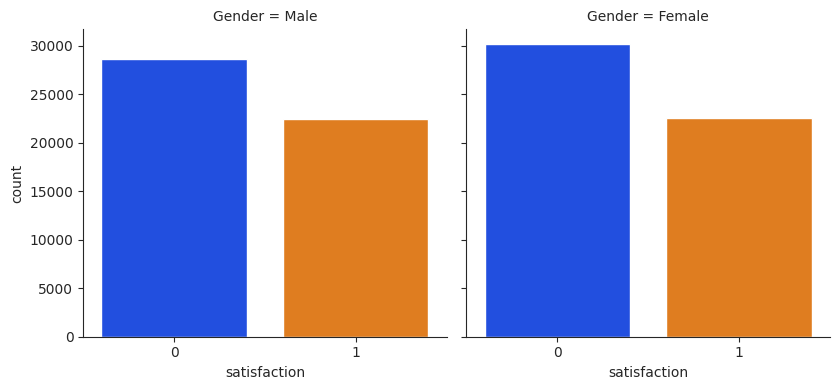

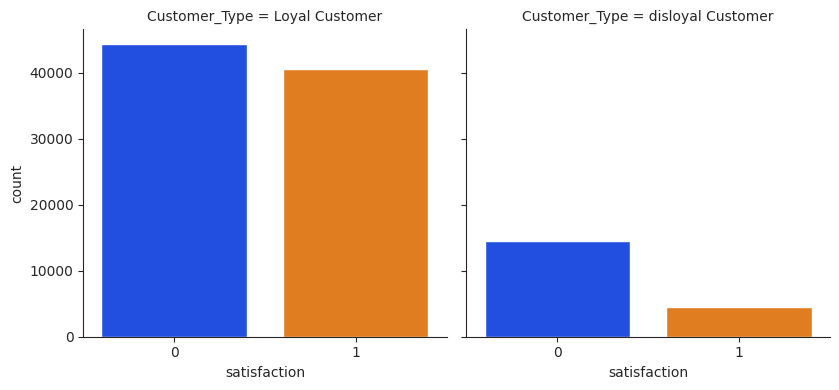

In [ ]:
#@title Gender & Customer_Type vs satisfaction plot
import seaborn as sns
with sns.axes_style(style='ticks'):
    g = sns.catplot(x="satisfaction", col="Gender", col_wrap=5, data=airline_train_df, kind="count", height=4, aspect=1.0,palette="bright")
    g = sns.catplot(x="satisfaction", col="Customer_Type", col_wrap=5, data=airline_train_df, kind="count", height=4, aspect=1.0,palette="bright")

Jest zauważalne, że ze względu na płeć rozkład zadowolonych i niezadowolonych klientów jest taki sam. Zarówno dla mężczyzn, jak i kobiet liczba niezadowolonych/neutralnych klientów jest większa w porównaniu z liczbą zadowolonych klientów.

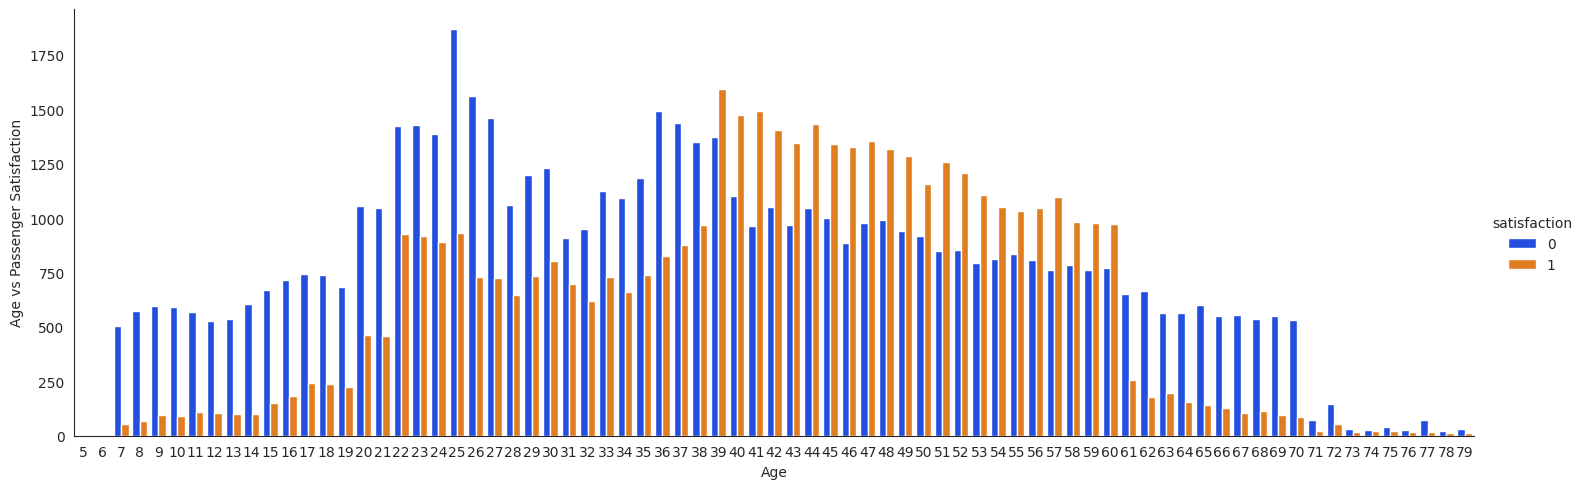

In [ ]:
#@title Age vs satisfaction plot
with sns.axes_style('white'):
    g = sns.catplot(x="Age", data=airline_train_df, aspect=3.0, kind='count', hue='satisfaction', order=range(5, 80),palette="bright")
    g.set_ylabels('Age vs Passenger Satisfaction')

W zakresie wiekowym od 7 do 38 lat widoczna jest przewada niezadowolonych klientów, natomiast w zakresie 39-60 liczba usatysfakcjonowych klientów przeważa nad klientami przynależącymi do klasy negatywnej.

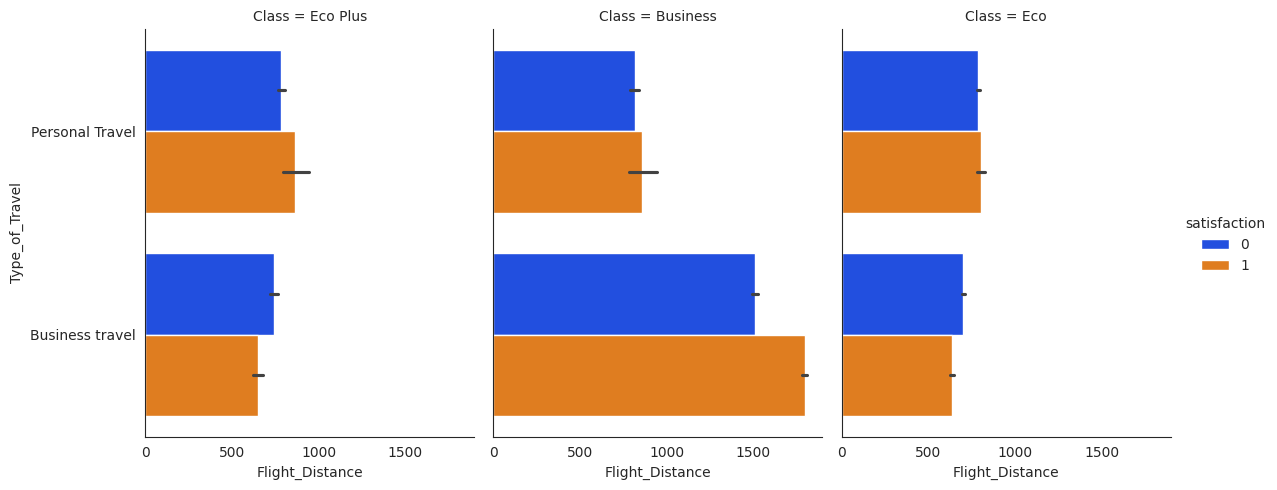

In [ ]:
#@title Class travel vs flight_distance plot
with sns.axes_style('white'):
    g = sns.catplot(x="Flight_Distance", y="Type_of_Travel", hue="satisfaction", col="Class", data=airline_train_df, kind="bar", height=5, aspect=.8,palette="bright")

Dla podróży biznesowych w kategorii klasy biznes, liczba zadowolonych pasażerów stanowi większą część dla podróży dłuższych. Dla pozostałych wariantów, rozkład zadowolonych/niezadowolonych klientów jest jednakowy.

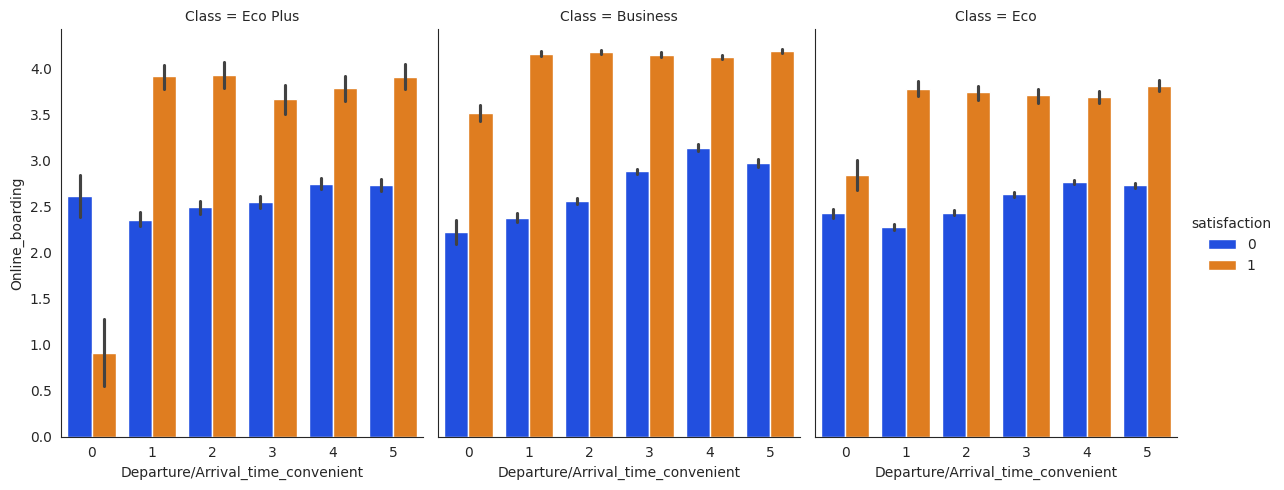

In [ ]:
#@title Class plot vs departure/arrival_time_convenient plot
with sns.axes_style('white'):
    g = sns.catplot(x="Departure/Arrival_time_convenient", y="Online_boarding", hue="satisfaction", col="Class", data=airline_train_df, kind="bar", height=5, aspect=.8,palette="bright")

Dla klasy "Eco Plus" bardzo niekorzystny czas odjazdu/przybycia ma największą procent niezadowolonych pasażerów, nawet jeśli online boarding jest przeprowadzony poprawnie.

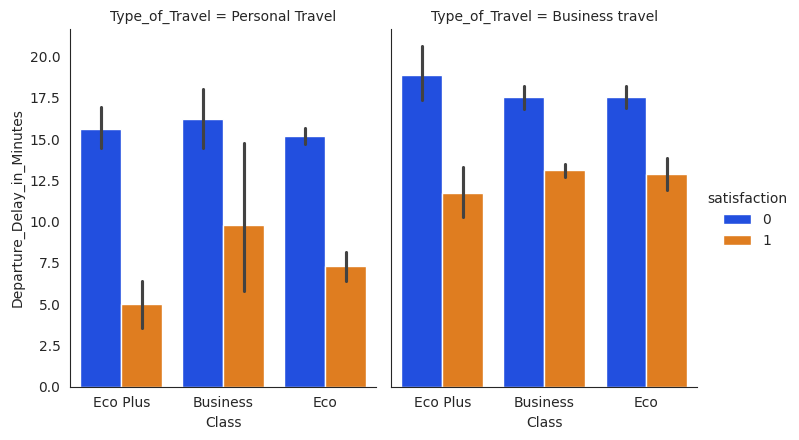

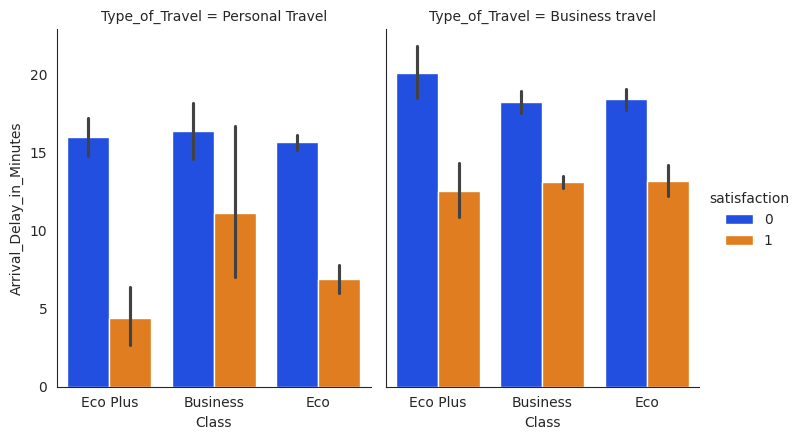

In [ ]:
#@title Type_of_travel vs Class travel vs Arrival/Departure_Delay_In_Minutes plot
with sns.axes_style('white'):
    g = sns.catplot(x="Class", y="Departure_Delay_in_Minutes", hue="satisfaction", col="Type_of_Travel", data=airline_train_df, kind="bar", height=4.5, aspect=.8,palette="bright")
    g = sns.catplot(x="Class", y="Arrival_Delay_in_Minutes", hue="satisfaction", col="Type_of_Travel", data=airline_train_df, kind="bar", height=4.5, aspect=.8,palette="bright")

Dla podróży osobistych (zwłaszcza "Eco" i "Eco Plus"), liczba niezadowolonych klientów jest duża, jeśli czas przybycia w minutach jest wysoki.

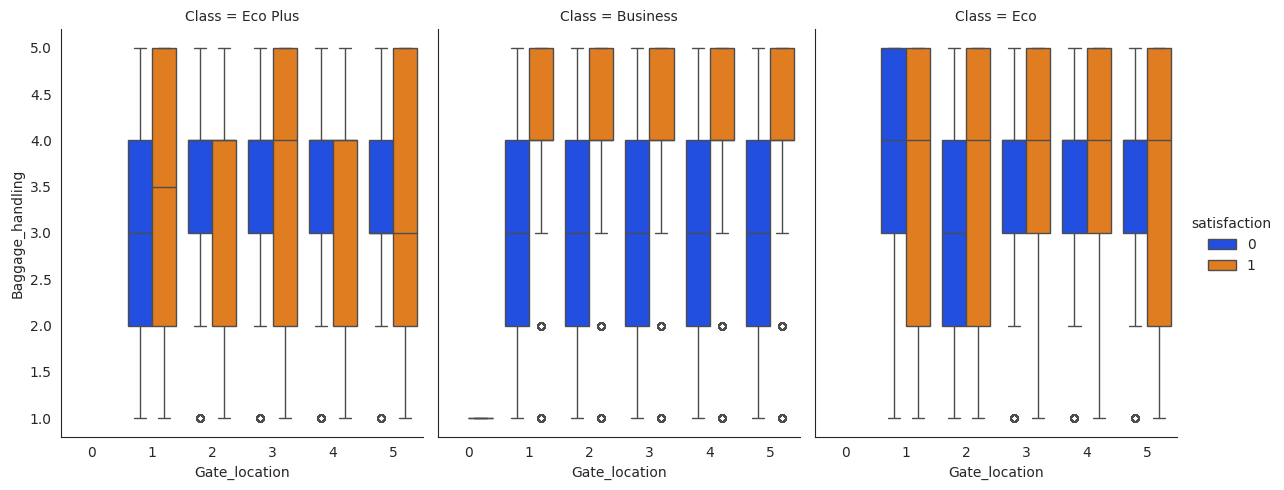

In [ ]:
#@title Gate_location vs Class travel vs Baggage_handling plot
with sns.axes_style('white'):
    g = sns.catplot(x="Gate_location", y="Baggage_handling", hue="satisfaction", col="Class", data=airline_train_df, kind="box", height=5, aspect=.8,palette="bright")

Dla klasy biznes, zauważalne jest, że lokalizacje bramek mają większą liczbę niezadowolonych klientów, jeśli obsługa bagaży nie jest zrobiona prawidłowo.

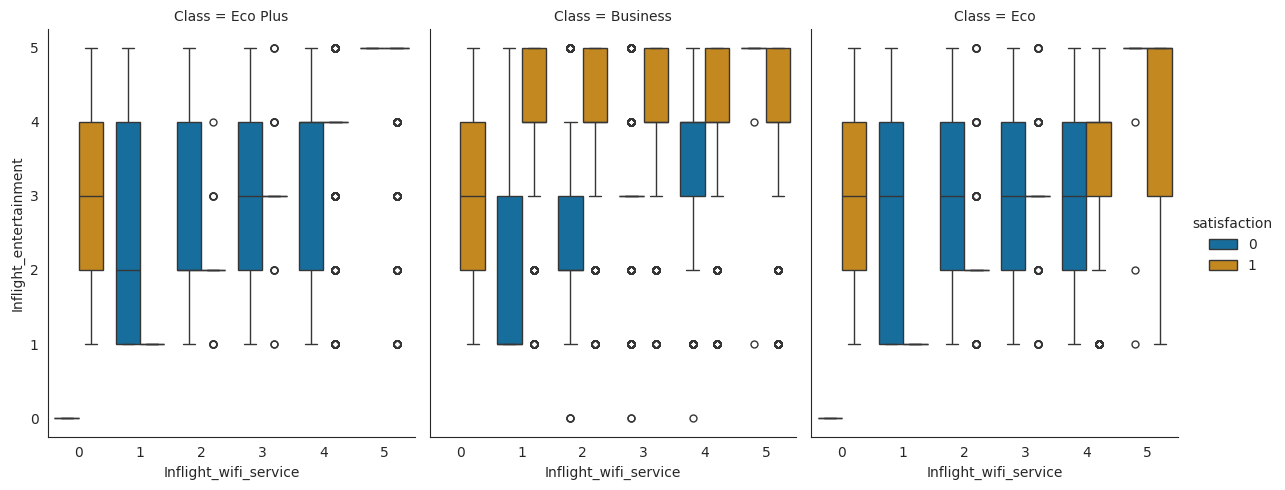

In [ ]:
#@title Inflight_wifi_service vs Class travel vs Inflight_entertainment plot
with sns.axes_style('white'):
    g = sns.catplot(x="Inflight_wifi_service", y="Inflight_entertainment", hue="satisfaction", col="Class", data=airline_train_df, kind="box", height=5, aspect=.8,palette="colorblind")

Dla pasażerów klasy "Eco Plus" podróż jest zadowalająca, jeśli na pokładzie nie ma usługi wi-fi i jest średni poziom rozrywki pokładowej. Dla klasy biznes, tylko najwyższy poziom rozrywki pokładowej, powoduje ich satysfakcję.

#### Korelacje pomiędzy atrybutami

<Axes: >

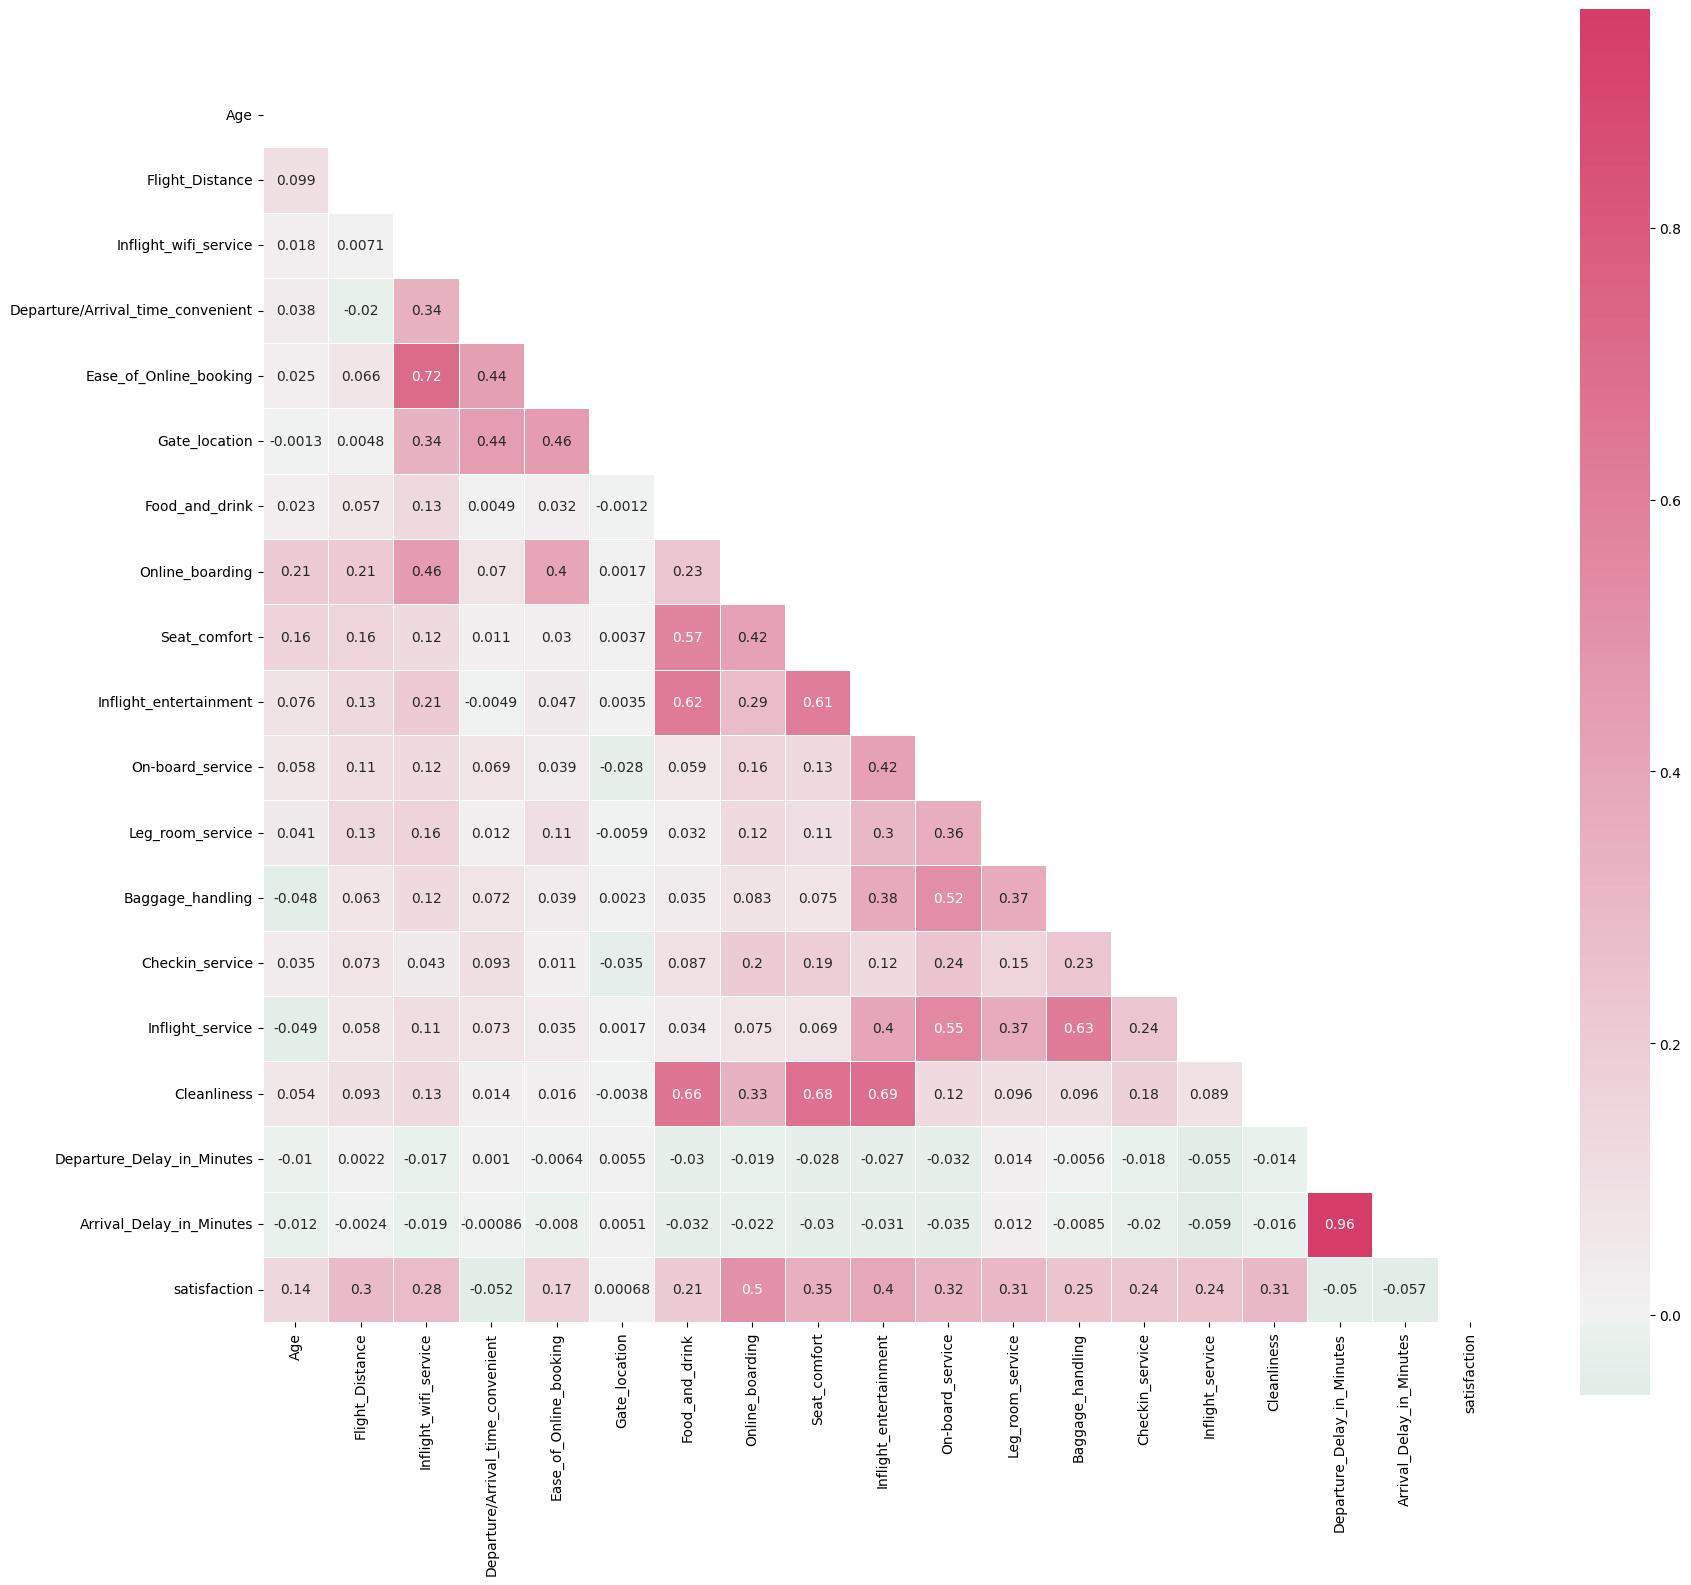

In [ ]:
#@title Features correlation plot
corr = airline_train_df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=np.bool_))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(150, 1, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

Największa korelacja występuje pomiędzy czasem przylotu i odlotu, łatwością zarezerwowania przelotu online i usługami wi-fi na pokładzie samolotu, czystością i usługami obowiązującymi na pokładzie.

### Architektura modelu
Do testów wykorzystana zostanie prosta architektura typu feed-forward wielowarstwowego perceptrona (MLP). Osobno obsługiwane będą atrybuty decyzyjne będące zmiennymi kategorycznymi, dla których wykorzystana zostanie warstwa zanurzeń. Będzie ona następnie po przetworzeniu z wykorzystaniem techniki dropout, łączona z przetworzonymi atrybutami ilościowymi po normalizacji wsadowej. Następnie stosowane są kolejne warstwy liniowe naprzemian z techniką dropout, normalizacji i funkcją aktywacji. Dokładna implementacja architektury (po zastosowaniu narzędzi AutoML), znajduje się poniżej.

In [ ]:
#@title Neural Network Architecture Code
class GeneralisedNeuralNetworkModel(nn.Module):
    def __init__(self, embedding_sizes, n_cont=7, n_class=1, dropout=0.3327, emb_dropout=0.2073, features=300):
        super().__init__()
        self.embeddings = nn.ModuleList(
            [nn.Embedding(categories, size) for categories, size in embedding_sizes]
        )
        n_emb = sum(e.embedding_dim for e in self.embeddings)
        self.n_emb, self.n_cont = n_emb, n_cont
        self.lin1 = nn.Linear(self.n_emb + self.n_cont, 200)
        self.lin2 = nn.Linear(200, features)
        self.lin3 = nn.Linear(features, n_class)
        self.bn1 = nn.BatchNorm1d(self.n_cont)
        self.bn2 = nn.BatchNorm1d(200)
        self.bn3 = nn.BatchNorm1d(features)
        self.emb_drop = nn.Dropout(emb_dropout)
        self.drops = nn.Dropout(dropout)

    def forward(self, x_cat, x_cont):
        x = [e(x_cat[:, i]) for i, e in enumerate(self.embeddings)]
        if len(x) != 0:
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
            x2 = self.bn1(x_cont)
            x = torch.cat([x, x2], 1)
        else:
            x = self.bn1(x_cont.float())
        x = F.relu(self.lin1(x))
        x = self.drops(x)
        x = self.bn2(x)
        x = F.relu(self.lin2(x))
        x = self.drops(x)
        x = self.bn3(x)
        x = self.lin3(x)
        return x

Przekształcenie zmiennych kategorycznych na odpowiadające poszczególnym wartościom ciągów znaków liczby. Zastosowany został algorytm *LabelEncoder*, etykietujący poszczególne wartości przyjmowane przez atrybuty od 0 do n-1. Tym samym w porównaniu z algorytmem *One-Hot Encoding* uzyskanie mniejsza liczba zmiennych po przetworzeniu oraz lepiej zostanie oddany charakter porządkowy tych zmiennych.

In [ ]:
#@title Label Encoding for categorical features
for col in airline_train_df.columns:
    if airline_train_df.dtypes[col] == "object":
        airline_train_df[col] = LabelEncoder().fit_transform(airline_train_df[col])
        airline_test_df[col] = LabelEncoder().fit_transform(airline_test_df[col])

In [ ]:
#@title Change object to categorical columns
numerical_cols = [
    "Age",
    "Flight_Distance",
    "Departure_Delay_in_Minutes",
    "Arrival_Delay_in_Minutes",
]
for col in airline_train_df.columns:
    if not col in numerical_cols:
        airline_train_df[col] = airline_train_df[col].astype("category")
        airline_train_df[col] = airline_train_df[col].astype("category")

In [ ]:
#@title Count embedding sizes for categorical columns
embedded_cols = {
    n: len(col.cat.categories)
    for n, col in airline_train_df.items()
    if col.dtype == "category" and len(col.cat.categories) > 2
}
embedded_col_names = embedded_cols.keys()
print(f"Embedded column names (categorical): {embedded_cols}")
embedding_sizes = [
    (n_categories + 1, min(50, (n_categories + 1) // 2))
    for _, n_categories in embedded_cols.items()
]

Embedded column names (categorical): {'Class': 3, 'Inflight_wifi_service': 6, 'Departure/Arrival_time_convenient': 6, 'Ease_of_Online_booking': 6, 'Gate_location': 6, 'Food_and_drink': 6, 'Online_boarding': 6, 'Seat_comfort': 6, 'Inflight_entertainment': 6, 'On-board_service': 6, 'Leg_room_service': 6, 'Baggage_handling': 5, 'Checkin_service': 6, 'Inflight_service': 6, 'Cleanliness': 6}


Klasa reprezentująca zbiór danych wejściowych w PyTorch. Wykorzystana zostanie również funkcja do migracji danych na inne urządzenie, w szczególności kartę graficzną oraz klasa umożliwiająca przeniesienie obiektu typu DataLoader na kartę graficzną. W końcu zostanie wykorzystana także funkcja wybierająca jeden z pięciu algorytmów optymalizacyjnych do zbadania.

In [ ]:
#@title Airline Passengers Satisfaction class implementation in PyTorch, DeviceDataLoader class, to_device and get_optimizer functions
class AirlinePassengersDataset(Dataset):

    def __init__(self, X, y, embedded_col_names, transform=None) -> None:
        """
        Args:
            X: input data
            y: labels
            embedded_col_names: list of categorical column names
            transform (callable, optional): Optional transform to be applied on a sample
        """
        X = X.copy()
        self.X1 = X.loc[:, embedded_col_names].copy().values.astype(np.int64)
        self.X2 = X.drop(columns=embedded_col_names).copy().values.astype(np.float32)
        self.y = y.copy().values.astype(np.float32)
        # self.id = np.arange(len(self.y))
        # self.difficulties = np.zeros(len(self.y), dtype=np.float32)

        self.transform = transform

    def __getitem__(self, index: int):
        sample = (
            # self.id[index],
            self.X1[index],
            self.X2[index],
            self.y[index],
            # self.difficulties[index],
        )

        if self.transform:
            sample = self.transform(sample)

        return sample

    def __len__(self):
        return len(self.y)

class DeviceDataLoader:
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

# function to move data to device (CUDA)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# function to change optimizer
def get_optimizer(model, optimizer="Adam", lr=0.001, wd=0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    if optimizer == "Adam":
        optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    elif optimizer == "Adagrad":
        optim = torch.optim.Adagrad(parameters, lr=lr, weight_decay=wd)
    elif optimizer == "Adadelta":
        optim = torch.optim.Adadelta(parameters, lr=lr, weight_decay=wd)
    elif optimizer == "RMSprop":
        optim = torch.optim.RMSprop(parameters, lr=lr, weight_decay=wd)
    else:
        optim = torch.optim.SGD(parameters, lr=lr, weight_decay=wd)

    return optim

Inicjalizacja zbiorów treningowego i walidacyjnego.

In [ ]:
#@title Train and valid datasets initialization
X, y = airline_train_df.iloc[:, :-1], airline_train_df.iloc[:, [-1]]
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.10, random_state=0
)
train_ds = AirlinePassengersDataset(X_train, y_train, embedded_col_names)
valid_ds = AirlinePassengersDataset(X_val, y_val, embedded_col_names)

Ustalenie wielkości batcha, inicjalizacja urządzenia, na którym będą wykonywane obliczenia, przeniesienie zbioru danych do obiektu typu DataLoader dzielącego zbiór danych na paczki danych

In [ ]:
#@title Device, batch_size initialization, move train and valid datasets to CUDA if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
batch_size = 512

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

Funkcje reprezentujące przebieg procesu uczenia i walidacji modelu podczas jednej epoki.

In [ ]:
#@title Training and validation loop functions
# training loop
def train_gnn_model(
    model: GeneralisedNeuralNetworkModel,
    optim,
    train_dl: DataLoader,
    epoch: int,
) -> float:
    model.train()
    total = 0
    sum_loss = 0
    print("Running training loop")
    loss_fn = nn.BCEWithLogitsLoss()
    with tqdm(train_dl, unit="batch") as tepoch:
        for x1, x2, y in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}")
            batch = y.shape[0]
            output = model(x1, x2)

            loss = loss_fn(output, y)

            optim.zero_grad()
            loss.backward()
            optim.step()
            total += batch
            sum_loss += batch * (loss.item())

            tepoch.set_postfix(loss=sum_loss / total)

    return sum_loss / total

# validation loop
def validate_gnn_loss(
    model: GeneralisedNeuralNetworkModel,
    valid_dl: DataLoader,
    epoch: int,
) -> Tuple[float, float, list, list]:
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    all_preds, all_labels = [], []
    print("Running validation loop")
    loss_fn = nn.BCEWithLogitsLoss()

    with tqdm(valid_dl, unit="batch") as tepoch:
        for x1, x2, y in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}")
            current_batch_size = y.shape[0]
            out = model(x1, x2)

            preds = F.sigmoid(out).round()

            all_preds.extend(preds.cpu().detach().numpy().astype(int).tolist())
            all_labels.extend(y.cpu().detach().numpy().astype(int).tolist())

            loss = loss_fn(out, y)

            sum_loss += current_batch_size * (loss.item())
            total += current_batch_size
            correct += (preds == y).float().sum()

            tepoch.set_postfix(
                loss=sum_loss / total, accuracy=(correct / total).cpu().item()
            )

    all_labels = np.squeeze(np.array(all_labels).astype(int)).tolist()
    all_preds = np.squeeze(np.array(all_preds).astype(int))
    return sum_loss / total, correct / total, all_preds, all_labels

Inicjalizacja stałych wartości *learning rate* i *weight decay*, a także liczby epok uczenia. Deklaracja testowanych algorytmów optymalizacyjnych. Rysowanie wartości metryk dla poszczególnych epok na wykresach dla każdego optymalizatora.

In [ ]:
#@title Learning rate, weight decay, epochs number initialization, model training loop for each epoch with different optimizers implementation, plotting functions
lr = 0.001
wd = 0.0
epochs = 30

# plt.figure(figsize=(12, 8))
fig, axs = plt.subplots(2, 2)
epochs_nums = list(range(1, epochs + 1))
optimizers = ["SGD", "Adagrad", "RMSprop", "Adadelta", "Adam"]
models = []

for optimizer in optimizers:
    print("Training for optimizer:", optimizer)
    training_losses, validation_losses, accuracies, roc_auc_scores = [], [], [], []
    model = GeneralisedNeuralNetworkModel(embedding_sizes)
    to_device(model, device)
    optim = get_optimizer(model, optimizer=optimizer, lr=lr, wd=wd)
    for i in range(epochs):
        loss = train_gnn_model(model, optim, train_dl, i)
        val_loss, acc, all_preds, all_labels = validate_gnn_loss(model, valid_dl, i)
        training_losses.append(loss)
        validation_losses.append(val_loss)
        accuracies.append(acc.detach().cpu().item())

        roc_auc = roc_auc_score(all_labels, all_preds)
        roc_auc_scores.append(float(roc_auc))

    axs[0, 0].plot(epochs_nums, training_losses, label=optimizer)
    axs[0, 1].plot(epochs_nums, validation_losses, label=optimizer)
    axs[1, 0].plot(epochs_nums, accuracies, label=optimizer)
    axs[1, 1].plot(epochs_nums, roc_auc_scores, label=optimizer)
    models.append(model)


axs[0, 0].set_title("Training loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss value")
axs[0, 1].set_title("Validation loss")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Loss value")
axs[1, 0].set_title("Validation Accuracy")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Accuracy value")
axs[1, 1].set_title("ROC AUC scores")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("ROC AUC value")

handles, labels = axs[1, 1].get_legend_handles_labels()
fig.set_figheight(20)
fig.set_figwidth(18)
fig.legend(handles, labels, loc="upper right")
fig.suptitle(f"Training plots for different optimizers")
# fig.savefig("optimizer_plots.png")

Rysowanie krzywych uczenia, wartości metryk dla nauczonych modeli.

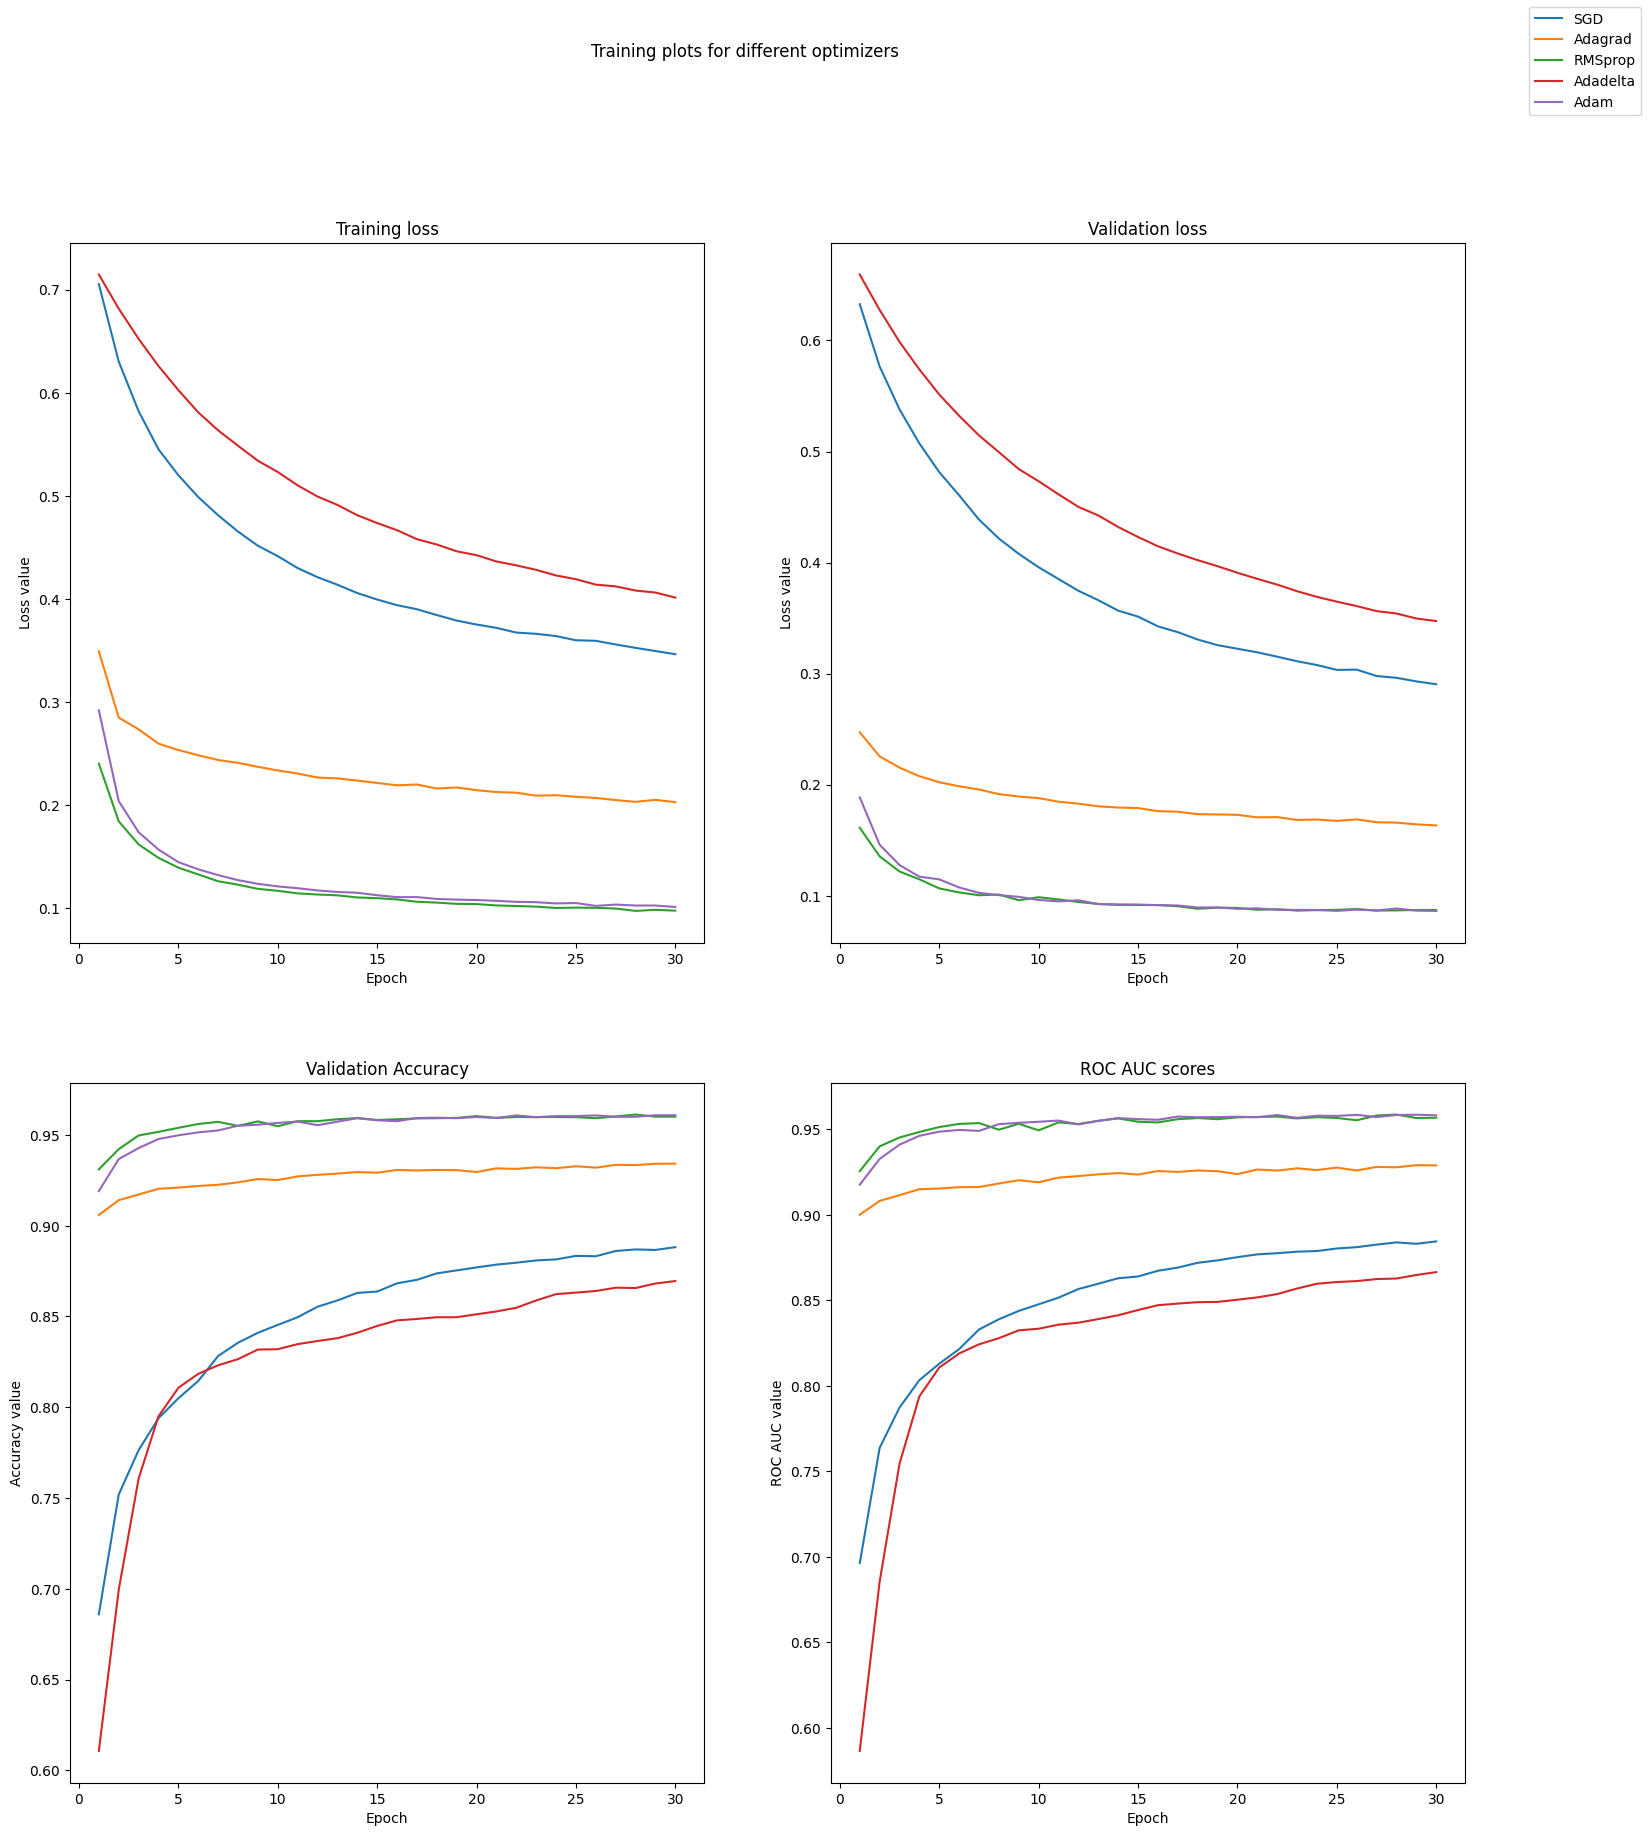

In [ ]:
#@title Show plots inside notebook
fig

Inicjalizacja zbioru testowego, przeniesienie do obiektu typu DataLoader oraz na odpowiednie urządzenie.

In [ ]:
#@title Test dataset initialization, move it to CUDA if available as DataLoader
X, y = airline_test_df.iloc[:, :-1], airline_test_df.iloc[:, [-1]]
test_ds = AirlinePassengersDataset(X, y, embedded_col_names)
test_dl = DataLoader(test_ds, batch_size=batch_size)
test_dl = DeviceDataLoader(test_dl, device)

Pętla testująca wytrenowane wcześniej modele dla każdego algorytmu optymalizacyjnego, prezentacja wyników modeli na zbiorze testowym.

In [ ]:
#@title Testing loop for each optimizer, show results of training different optimizers on test dataset
results = []

for i, optimizer in enumerate(optimizers):
    all_preds, all_labels = [], []
    total, correct = 0, 0
    model = models[i]
    model.eval()
    with torch.no_grad():
        for x1, x2, y in test_dl:
            current_batch_size = y.shape[0]
            out = model(x1, x2)

            y_pred_tags = F.sigmoid(out).round()
            correct += (F.sigmoid(out).round() == y).float().sum()

            all_preds.extend(y_pred_tags.cpu().detach().numpy().astype(int).tolist())
            all_labels.extend(y.cpu().detach().numpy().astype(int).tolist())

            total += current_batch_size

    all_labels = np.squeeze(np.array(all_labels).astype(int)).tolist()
    all_preds = np.squeeze(np.array(all_preds).astype(int)).tolist()

    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1score = f1_score(all_labels, all_preds)
    test_acc = round((correct / total).detach().cpu().item(), 3)

    results.append(dict(optimizer=optimizer, test_accuracy=test_acc, precision=round(precision, 3),
                        recall=round(recall, 3), f1_score=round(f1score, 3)))

    # print(f"Test accuracy for {optimizer} optimizer:", round((correct / total).detach().cpu().item(), 3))
    # print(f"Precision for {optimizer} optimizer:", round(precision, 3))
    # print(f"Recall for {optimizer} optimizer:", round(recall, 3))
    # print(f"F1-Score for {optimizer} optimizer:", round(f1score, 3))

results_df = pd.DataFrame(results)
print("Results on test set")
results_df

Results on test set


,optimizer,test_accuracy,precision,recall,f1_score
0,SGD,0.891,0.890,0.857,0.873
1,Adagrad,0.935,0.959,0.891,0.924
2,RMSprop,0.964,0.979,0.938,0.958
3,Adadelta,0.865,0.851,0.838,0.845
4,Adam,0.965,0.974,0.945,0.959


## Wnioski
Przedstawione powyżej krzywe uczenia oraz wyniki dla poszczególnych modeli wykorzystujących różne algorytmy optymalizacyjne, pokazują wpływ właściwego doboru optymalizatora na wytrenowanie finalnego modelu. Najlepiej zaprezentowały się algorytmy *Adam* oraz *RMSprop*, dla których krzywe uczenia zbiegają najszybciej oraz modele uzyskują najlepszą jakość klasyfikacji i wartość ROC-AUC.

Algorytm *Adam* łączy koncepcję zaniku sumy kwadratów gradientu wywodzącej się z *RMSprop* wraz z koncepcją momentum dla stochastycznego spadku gradientu. Jest to najlepszy i najpopularniejszy obecnie algorytm optymalizacyjny i najpewniej dla trudniejszych niż omawiany problemach poradziłby sobie lepiej niż *RMSprop*. Pozostałe algorytmy uzyskały gorsze rezultaty, w szczególności *Adadelta* i *SGD*.

*Adadelta* agreguje gradienty na podstawie przesuwającego się okna i dla tego problemu nie sprawdza się najlepiej. *RMSprop* jest wariacją *Adagrad* z odpowiednią normalizacją sumy kwadratów, dzięki czemu pozwala na uzyskanie lepszych wyników dla wytrenowanego modelu. *SGD* jest algorytmem najprostszym, lecz w niektórych sytuacjach bardzo skutecznym. Dla tego zadania jednak bardziej skomplikowane algorytmy optymalizacyjne pozwalają na dojście do lepszego obszaru przeszukiwanych rozwiązań.